In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.mlab as mlab
import scipy.optimize as opt
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

### 1 ###
a) Due to central limit theorem, assuming a gaussian distribution is usually the best idea.

b) A spherical (or isotropic) covariance matrix is when the covariance matrix is proportional to the identity matrix, which means it is diagonal, and all diagonal elements are exactly the same. 

### 2 ###

$$
p(\mathbf{Y} | f, \mathbf{X}) = p(\bigcap_i^N (y_i | f, x_i))
$$

### 3 ###

$$
p(\mathbf{Y} | \mathbf{X}, \mathbf{W}) = \prod_{n=1}^{N} N(y_i | w^T\phi(x_n), \beta^{-1})
$$


### 4 ###

Conjugate distributions occur when a prior and a posterior distribution are of the same family, in this case the prior is called a conjugate prior.

A conjugate prior is helpful, as if we choose to use a Gaussian conjugate prior, it ensures that our posterior is also a Gaussian, since Gaussian distributions are conjugate to themselves.
A conjugate prior gives a closed-form expression for the posterior, which prevents integration which may be otherwise necessary.
Additionally, conjugate priors can more easily show how a likelihood function updates the prior.

### 5 ###

A Gaussian distribution is parameterised on the L2 distance of a point from the mean of the distribution. If we encode the preference using L1 norm it will change the shape of out prior (Laplace distribution).
The change in shape of prior would also change the value of learned paramters since different priors mean different things.

![Screen%20Shot%202017-10-21%20at%2018.30.12.png](attachment:Screen%20Shot%202017-10-21%20at%2018.30.12.png)
On the left is a prior encoded using L2 norm and right is prior encoded using L1 norm

As you can see in the image the shape of the prior determines the parameters that are learned. The L2 norm places an equal importance in every direction whereas the L1 norm tends to bias parameters more toward the axes. This results in the L1 norm preferring certain dimension more than others.

### 6 ###

b) Has the form it does, which should be gaussian, because it is conjugate to the prior.

c) Z is used for normalisation, since the prior and posterior are conjugate, we know they are proportional, so Z is nothing more than a constant and shouldn't affect the actual model (?). Also can't be calculated.

### 7 ###

A non-parametric model is one that assumes the data distribution cannot be defined in terms of some finite parameters, and instead defines them by some infinite dimensional function.

The difference between parametrics and non-parametrics is mainly that the first assumes the model is entirely defined in terms of some finite parameters, which means that the parameters contain all the information on the model, and due to finite parameters, the complexity of the model is bounded and therefore not flexible.
However, for non-parametric models, the model is defined by a function relationship, and so the information the function contains grows as the amount of data grows, putting no bounds on the complexity and allowing the model to be more flexible.

### 9 ###

This prior encodes all possible functions, and this can be shown by looking at the spherical gaussian as a long line of "slices". Each of these "slices" is a regular gaussian, and therefore never touches zero, stretching from negative to positive infinity. In the same way, we can view the places we can take one of these slices as infinite, as the x-axis stretches from positive to negative infinity, and so we have an infinite function space.

### 11 ###

c) It implies that the output is dependent on both the input data (X) as well as the function (the parameters, theta)

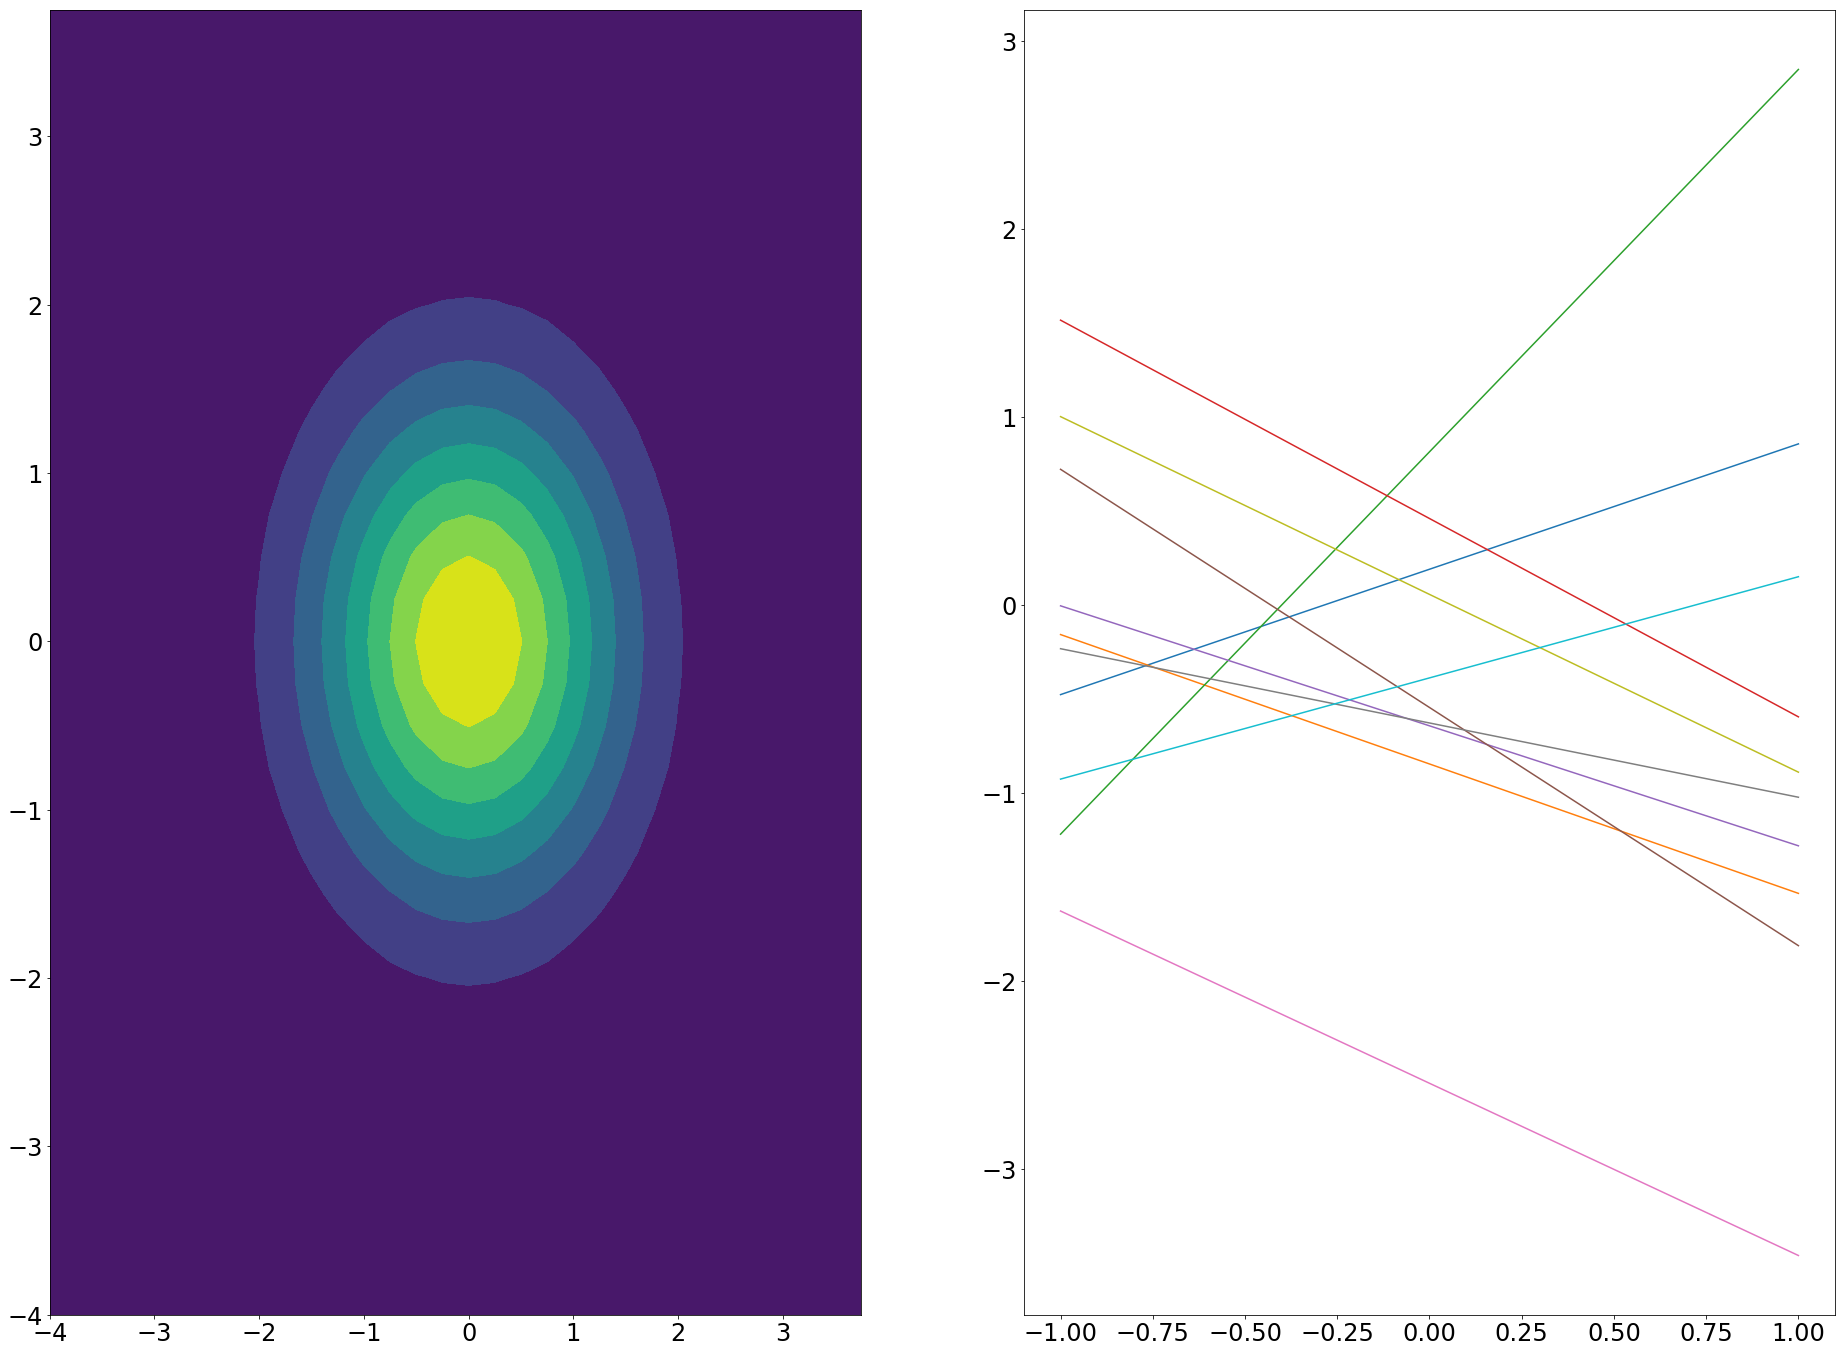

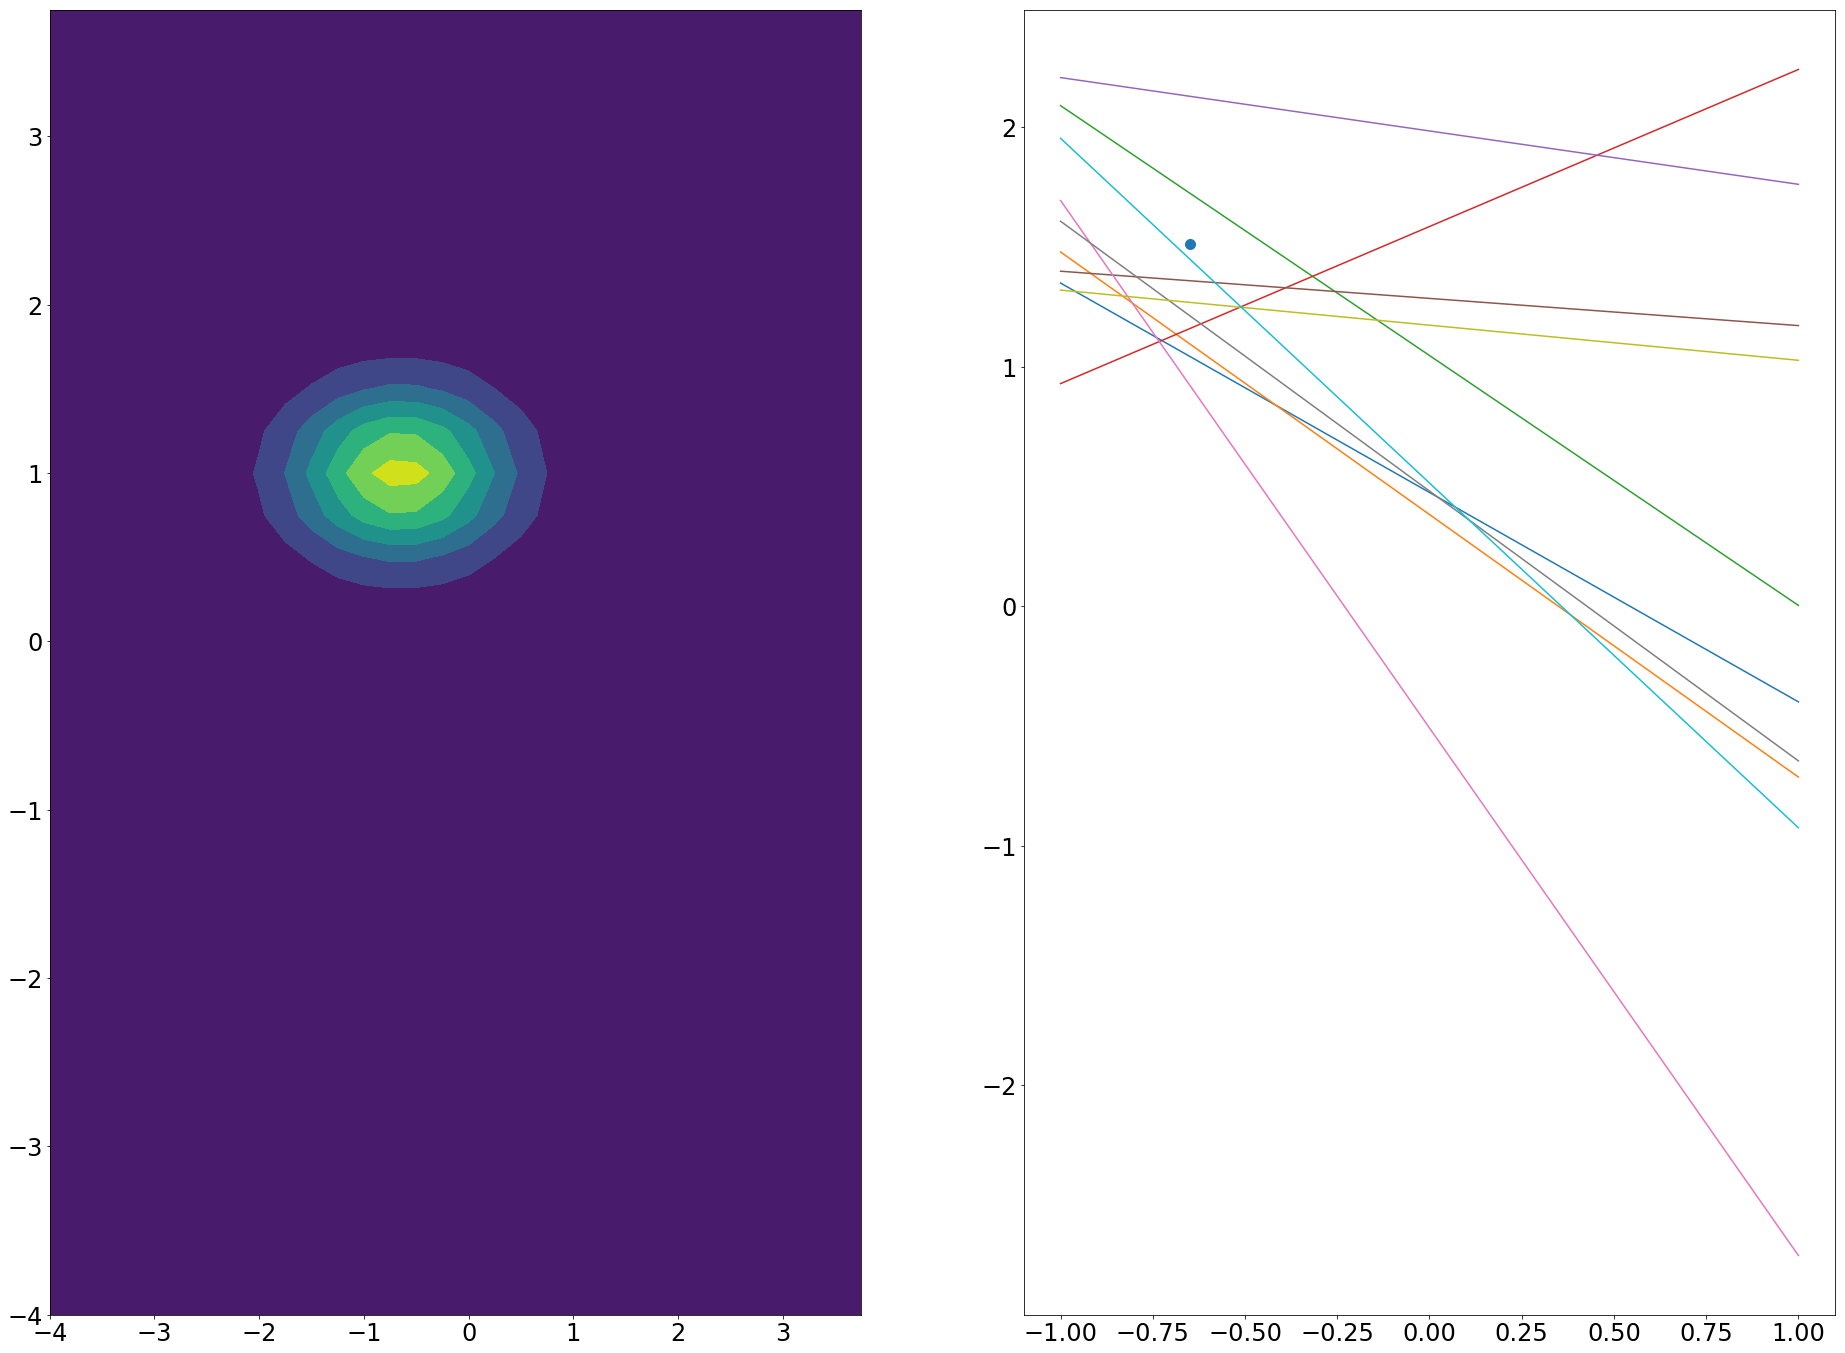

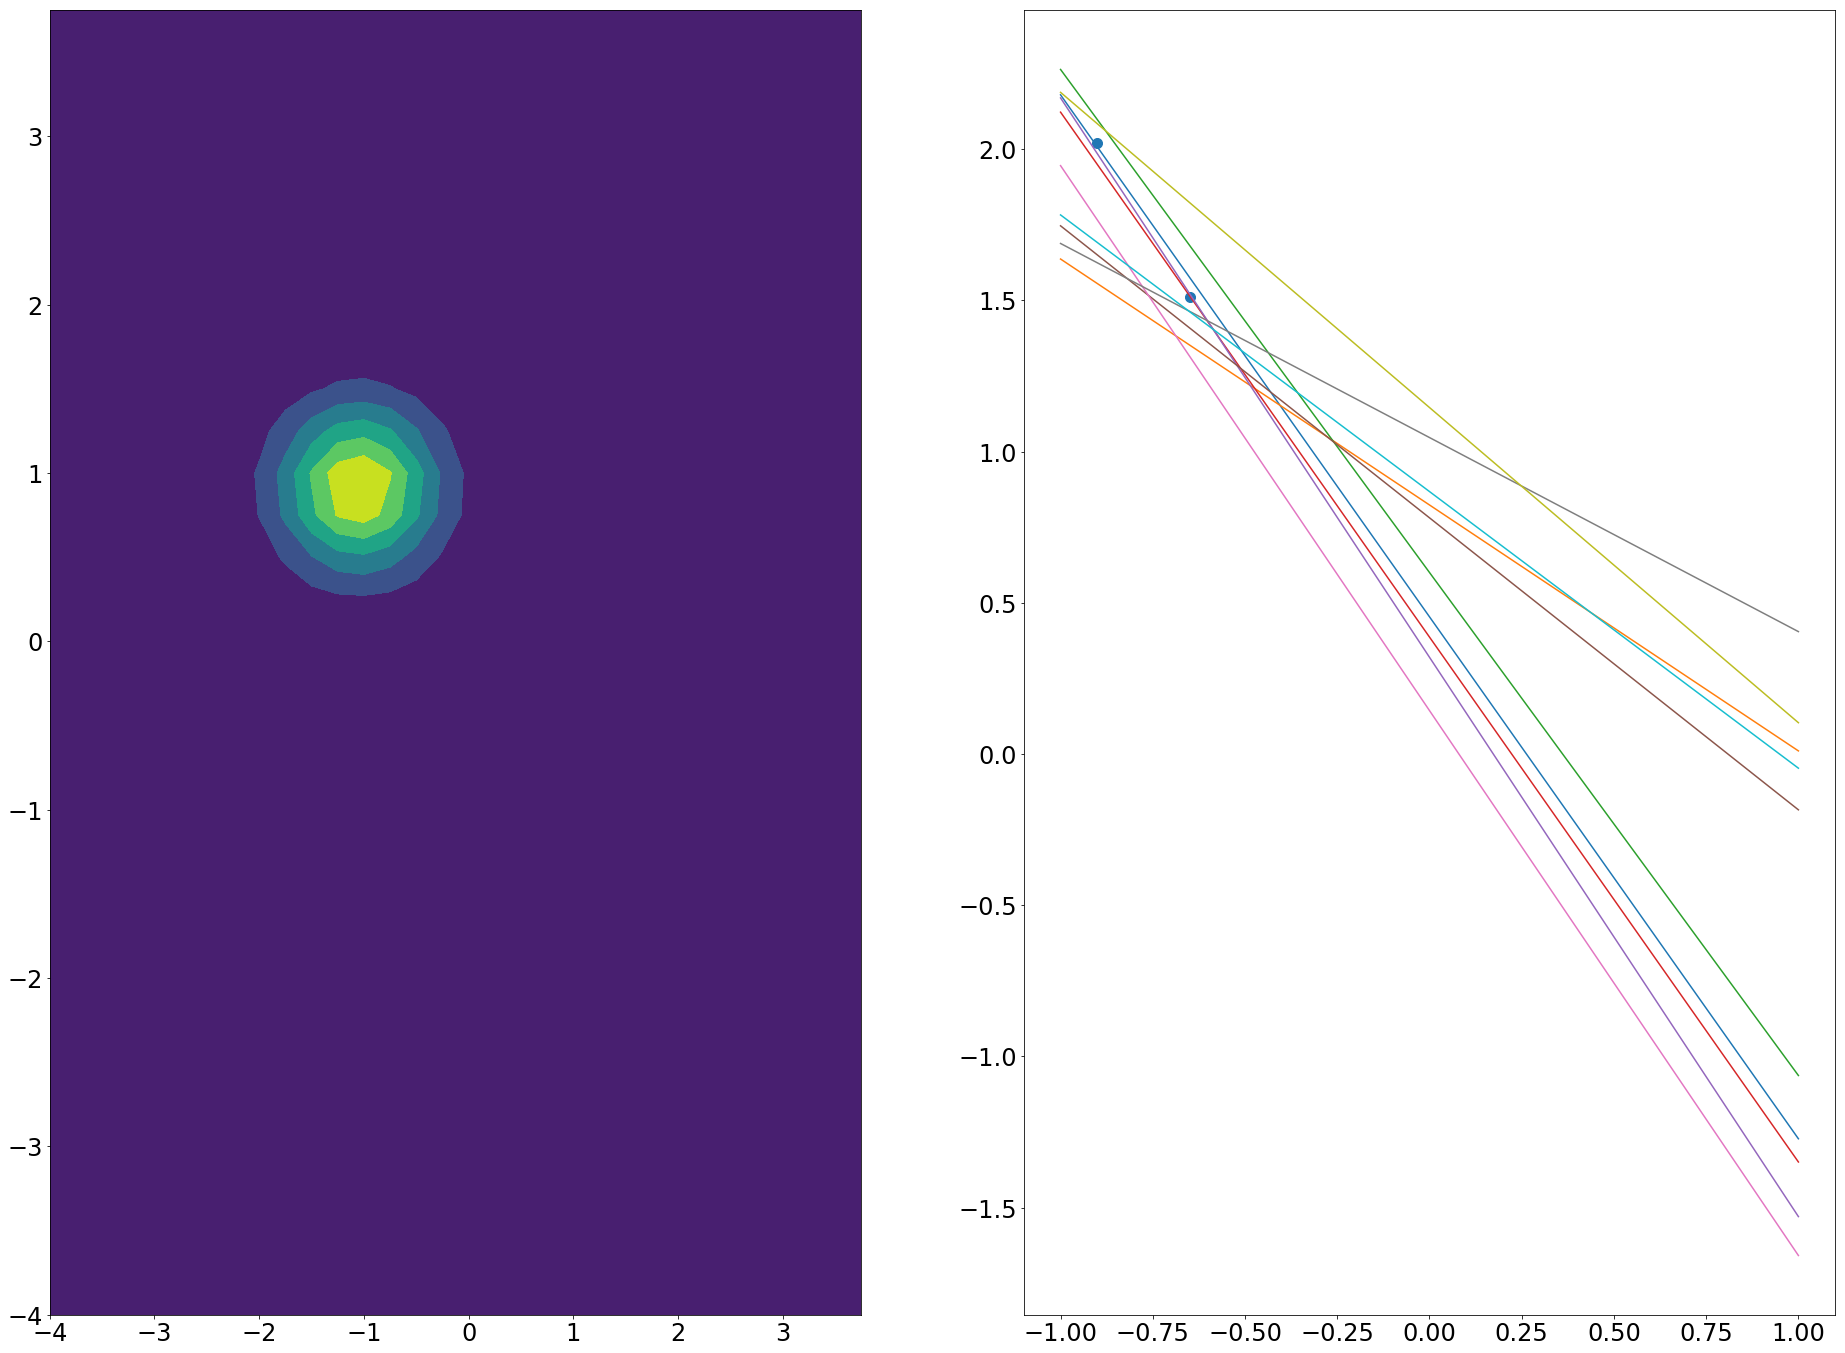

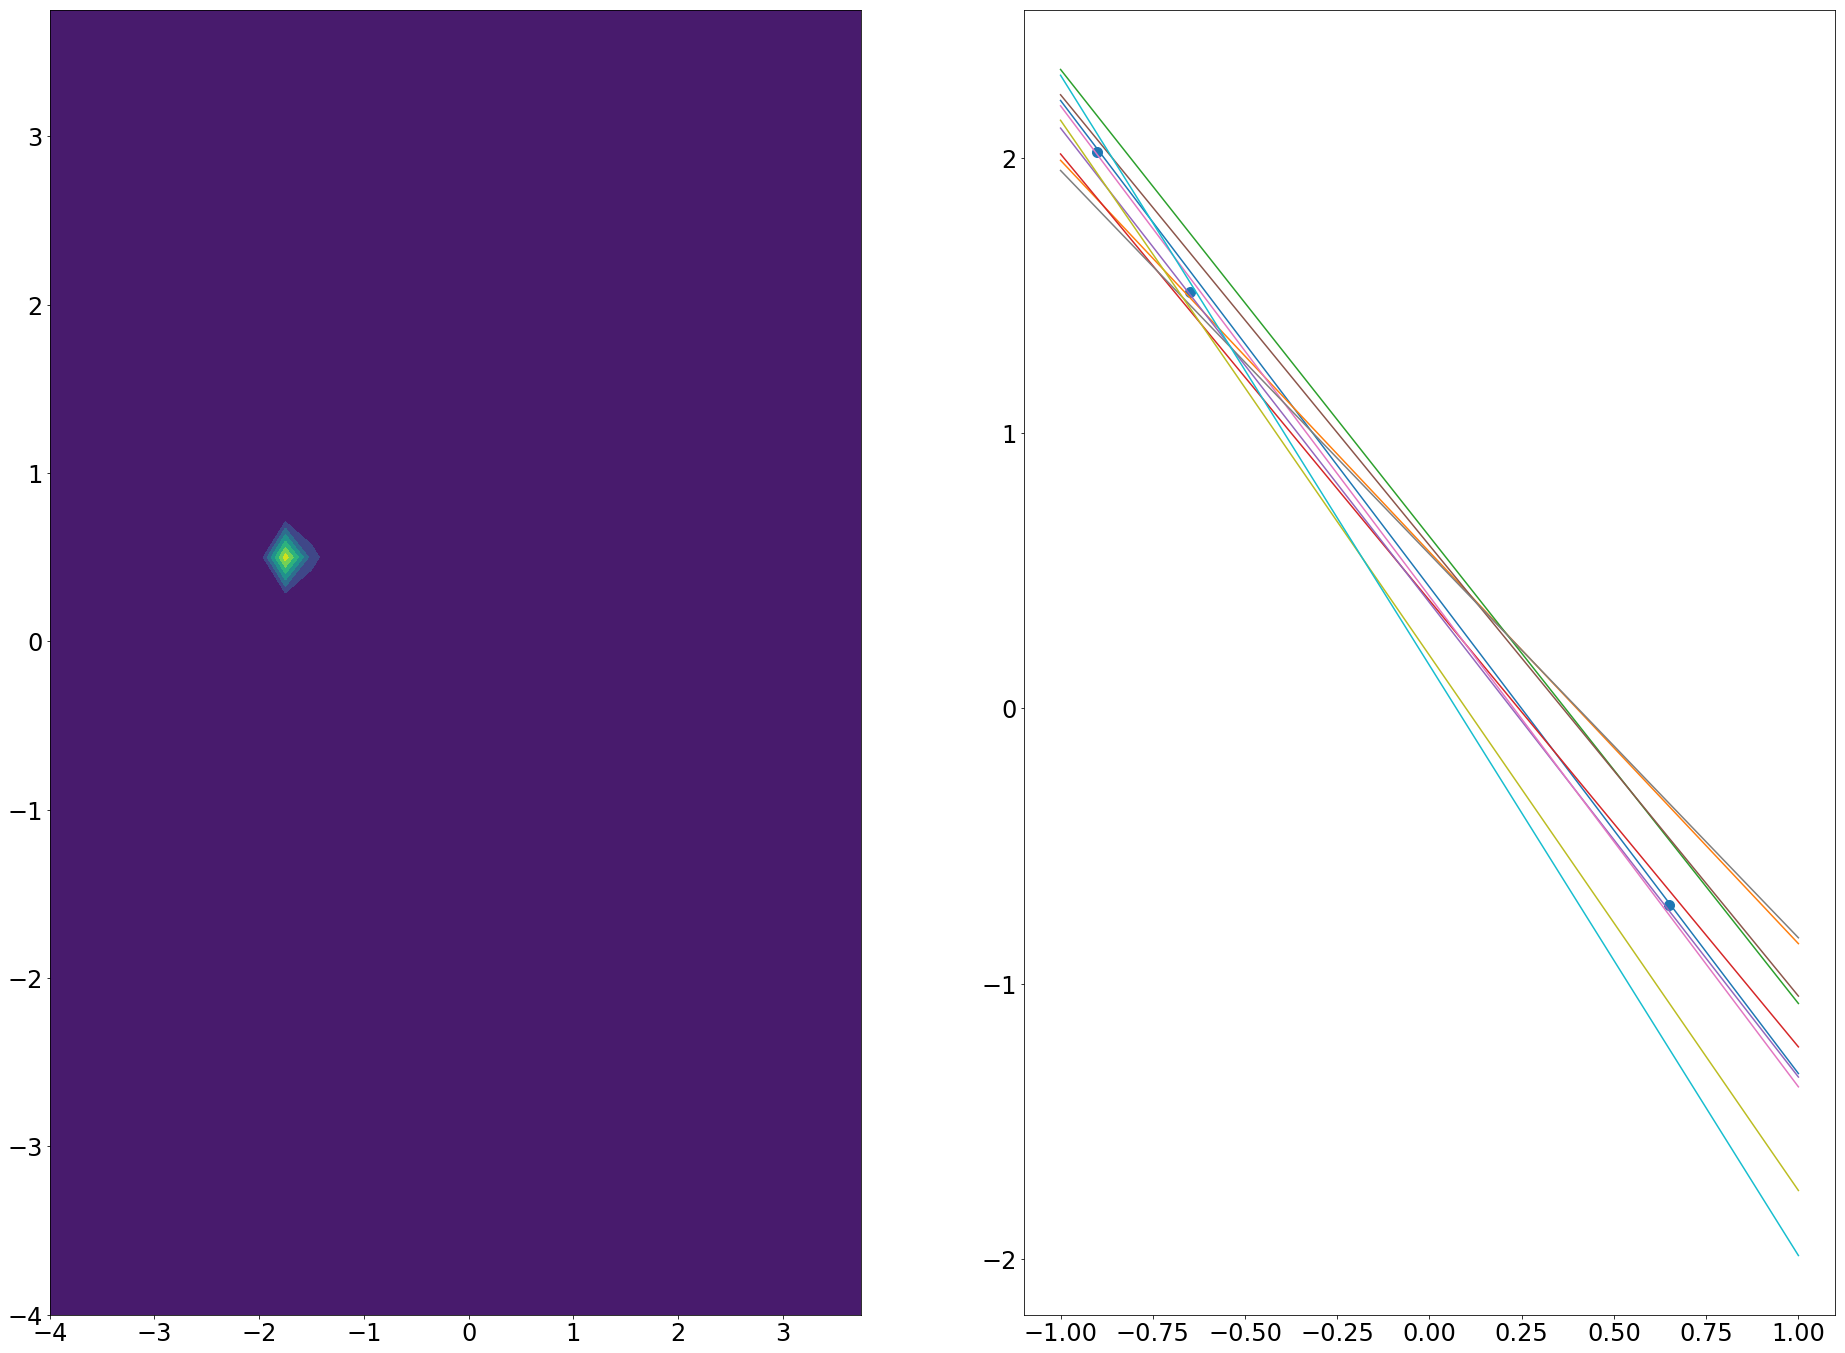

In [3]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def y_i(w, x):
    epsilon = np.random.normal(0, 0.3)
    return np.dot(w, x) + epsilon

def visualise(ax, mu, cov):
    for i in range(10):
        w = np.random.multivariate_normal(mu, cov)
        ax.plot([-1, 1], [np.dot(w, [-1, 1]), np.dot(w, [1, 1])])

tau = 1
beta = (1/0.3) ** 2
w0 = [0, 0]

x = np.arange(0.01, 1.01, 0.01)
x = np.concatenate(((np.multiply(-1, list(reversed(x)))), [0], x))
W = [-1.3, 0.5]
y = [y_i(W, [x_i, 1]) for x_i in x]
cov = tau ** 2 * np.identity(2)

delta = 0.25
xr = np.arange(-4.0, 4.0, delta)
yr = np.arange(-4.0, 4.0, delta)
X, Y = np.meshgrid(xr, yr)
Z = mlab.bivariate_normal(X, Y, cov[0, 0], cov[1, 1], w0[0], w0[1])
fig = plt.figure()
ax = fig.add_subplot(121)
ax.contourf(X, Y, Z)
ax = fig.add_subplot(122)
visualise(ax, w0, cov)

xData, yData = unison_shuffled_copies(np.array(x), np.array(y))

mu = [w0]
sigma = [cov]
for i in range(3):
    xBias = np.ones((1, 2))
    xBias[:, 0] = xData[i]
    yCol = np.reshape(yData[i], (-1, 1))
    newSigma = np.linalg.inv(np.linalg.inv(sigma[i]) + beta * np.dot(xBias.T, xBias))
    sigma.append(newSigma)
    newMu = np.dot(newSigma, (np.dot(np.linalg.inv(sigma[i]), np.reshape(mu[i], (2,1))) + beta * np.dot(xBias.T, yCol)))
    newMu = newMu.flatten()
    mu.append(newMu)
    Z = mlab.bivariate_normal(X, Y, sigma[i+1][0][0], sigma[i+1][1][1], mu[i+1][0], mu[i+1][1])
    fig = plt.figure()
    ax = fig.add_subplot(121)
    ax.contourf(X, Y, Z)
    ax = fig.add_subplot(122)
    visualise(ax, mu[i+1], sigma[i+1])
    ax.scatter(xData[0:i+1], yData[0:i+1], s=100)

plt.show()

### 12 ###

On the left is the visualisation of the prior/posterior and on the right you can see a sample of functions from the prior/posterior.  
Adding the first data point we see that the posterior shifts and becomes smaller and the functions seem to pass through the general area of the data point. On adding more data points the posterior starts to converge on the parameters and the functions move closer together and are very closely aligned to the direction of the data points.

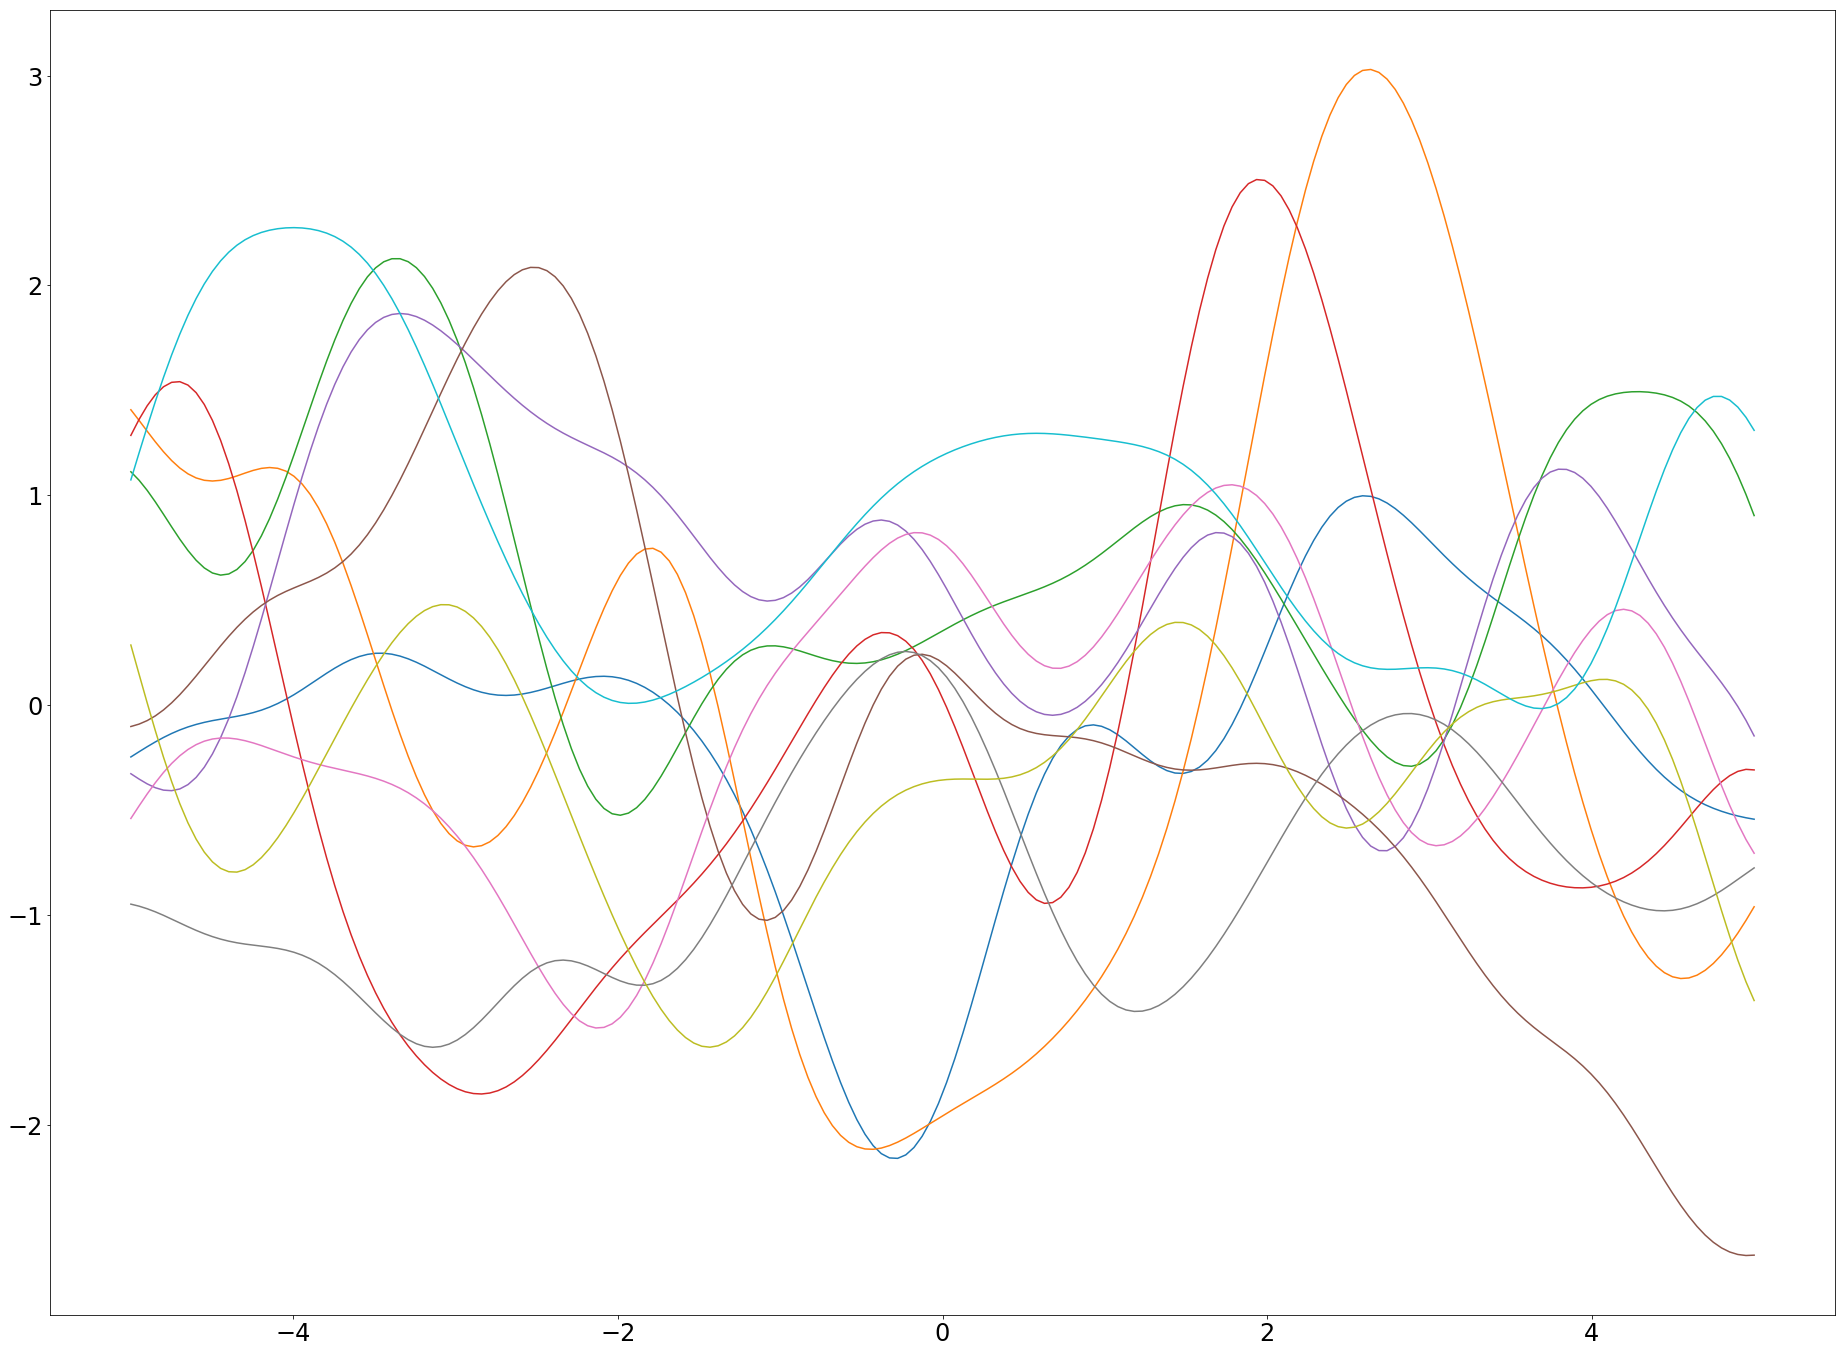

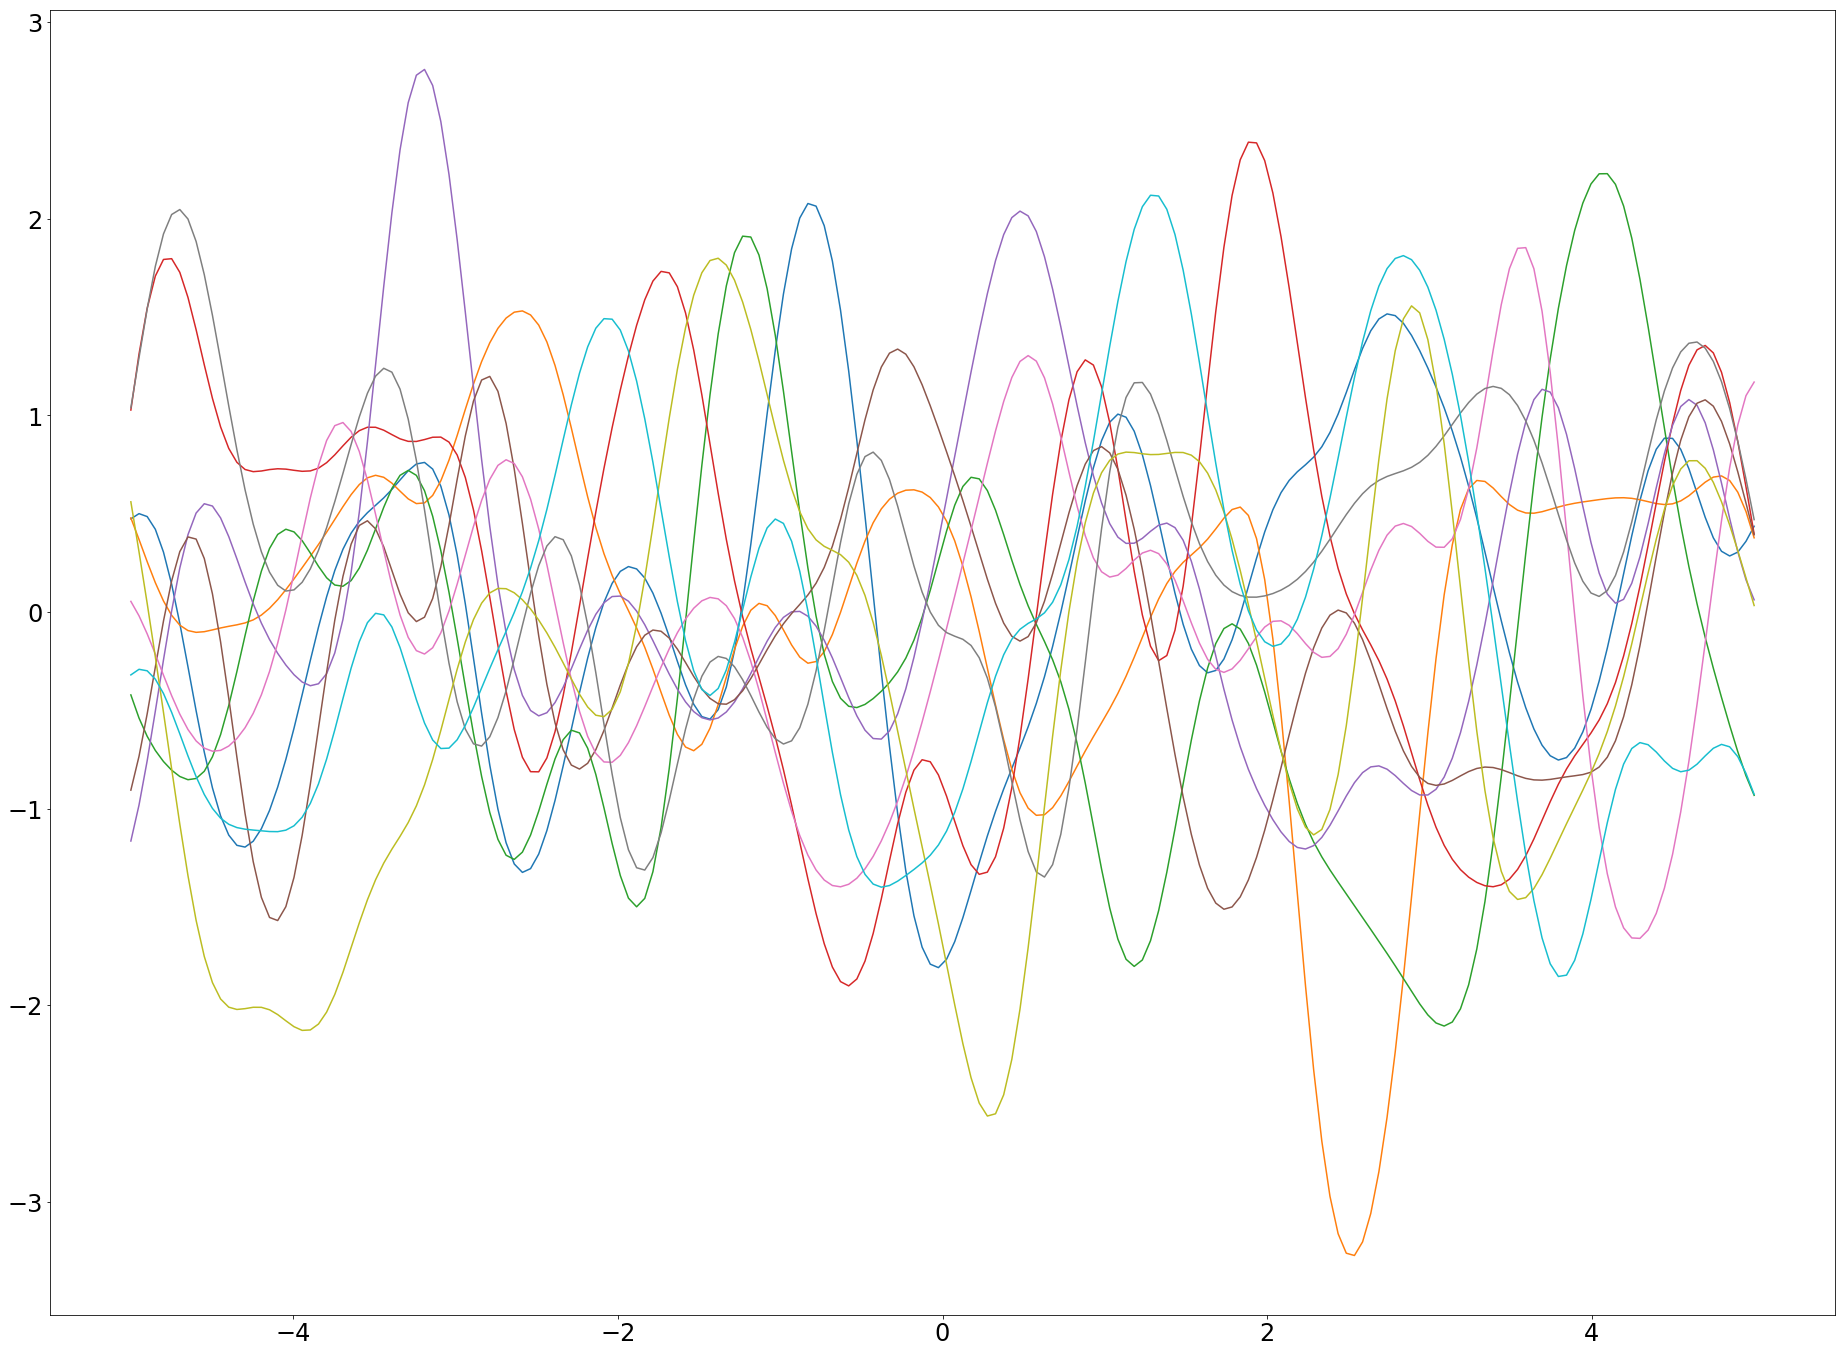

In [4]:
class Kernel:
    def __init__(self, sigma, lengthScale):
        self.sigma = sigma
        self.lengthScale = lengthScale
        
    def __call__(self, x_i, x_j):
        return (self.sigma ** 2) * np.exp(-1 * np.dot(np.transpose(x_i - x_j), (x_i - x_j)) * (1 / self.lengthScale ** 2))

data = np.linspace(-5, 5, 200)
kernel = Kernel(1, 1)
cov = np.reshape([kernel(x,y) for x in data for y in data], (len(data),len(data)))
mu = np.zeros(data.shape)

f = np.random.multivariate_normal(mu, cov, 10)

plt.plot(data, f.T)
plt.show()

kernel = Kernel(1, 0.5)
cov = np.reshape([kernel(x,y) for x in data for y in data], (len(data),len(data)))
mu = np.zeros(data.shape)

f = np.random.multivariate_normal(mu, cov, 10)

plt.plot(data, f.T)
plt.show()

### 13 ###

The first plot has value of length scale equal to 1 while the second one has length scale equal to 2.  
The length scale is directly proportional to the covariance of the Gaussian Process and we see that decreasing the value makes the functions noisier as the covariance decreases.

The length scale encodes the assumption of

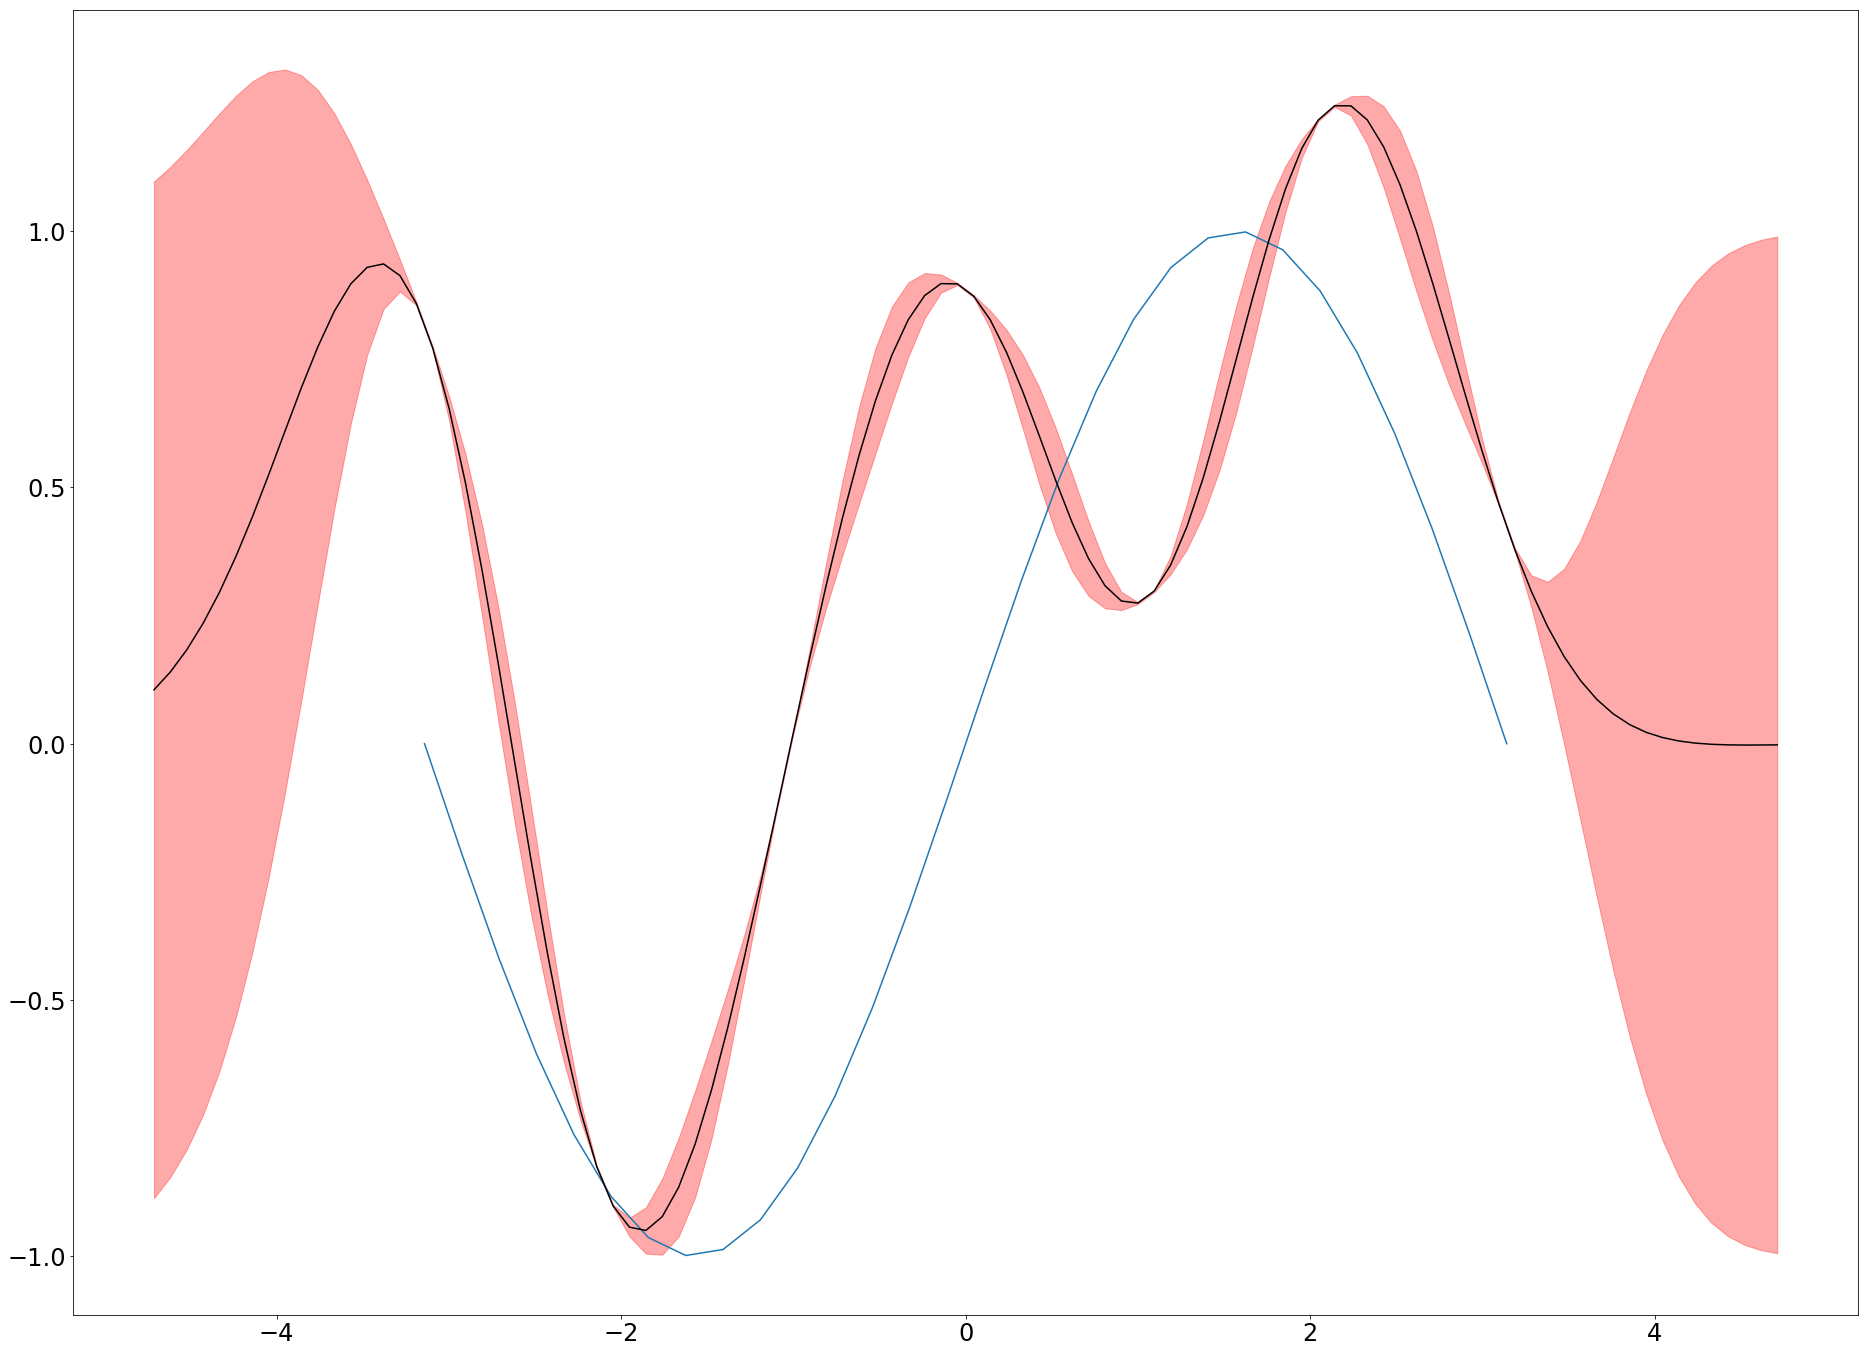

In [5]:
def y_i(x_i):
    return np.sin(x_i) + np.random.normal(0, 0.5)

x = np.linspace(-np.pi, np.pi, 7)
x = np.reshape(x, (-1,1))
y = [y_i(x_i) for x_i in x]
kernel = Kernel(1, 1)
K = np.reshape([kernel(x_i, y_i) for x_i in x for y_i in x], (len(x),len(x)))
mu = np.zeros(x.shape)

xD = np.linspace(-1.5*np.pi, 1.5*np.pi, 100)
yD = []
ySig = []
for i in xD:
    xData = i
    predMu = np.array([kernel(xData, x_i) for x_i in x]).reshape((1, -1)).dot(np.linalg.inv(K)).dot(y)
    predSig = kernel(xData, xData) - np.reshape([kernel(xData, x_i) for x_i in x], (1, -1)).dot(np.linalg.inv(K)).dot(np.reshape([kernel(x_i, xData) for x_i in x], (-1, 1)))
    yD.append(predMu.flatten())
    ySig.append(predSig.flatten())
    
xPlot = np.linspace(-np.pi, np.pi, 30)
xPlot = np.reshape(xPlot, (-1,1))
yPlot = [np.sin(x_i) for x_i in xPlot]
# yPlot = [y_i(x_i) for x_i in xPlot]
# plt.plot(x, y)
plt.plot(xPlot, yPlot)
plt.plot(xD, yD, color="black")
plt.fill_between(xD, np.add(yD, ySig).flatten(), np.subtract(yD, ySig).flatten(), color="#FF000055")
plt.show()

### 15 ###

The difference between a posterior and an assumption is merely contextual. The overarching idea behind them is the same, however depending on the situation or context of the model you are creating, the decision is made as to whether preference or assumption is the preferred term.
Both of these terms allow is to improve on our prior in some way, whether it be that we are "assuming" something about our input data, or we actually have some kind of "preference" to what form it takes.

### 16 ###

The assumption we have encoded with this prior is that all the parameters are equally important, shown by the identity matrix as a covariance matrix. Since there is no covariance between the separate parameters, we are showing they're all equally important and independent of each other.

         Current function value: 52275.500690
         Iterations: 7
         Function evaluations: 41
         Gradient evaluations: 30


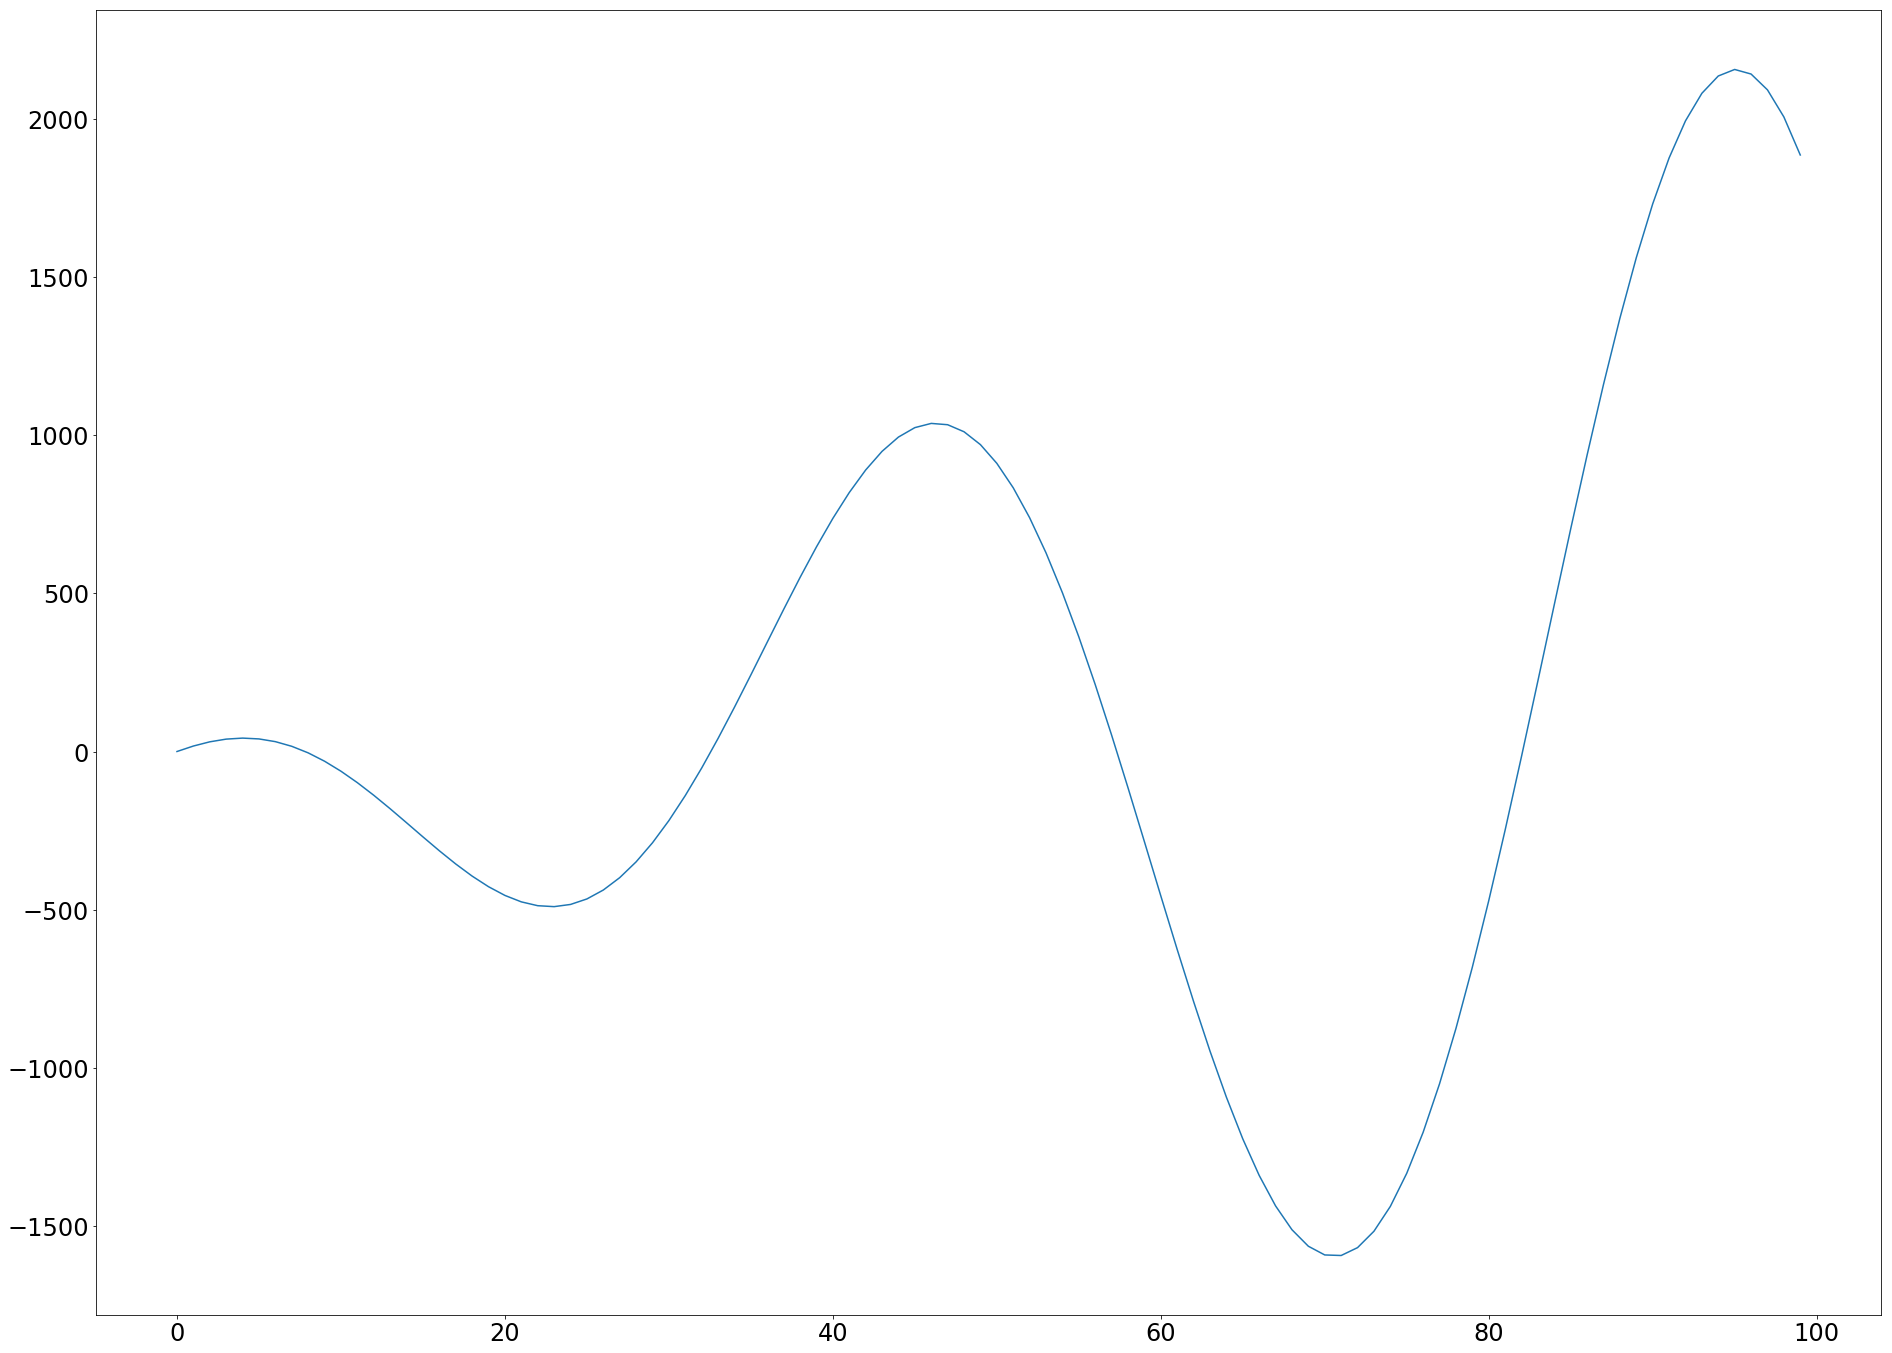

In [55]:
x = np.linspace(0, 4*np.pi, 100).reshape(-1, 1)
f_non_lin = np.hstack((np.multiply(x, np.sin(x)), np.multiply(x, np.cos(x))))
A = np.random.randn(10, 2)
y = A.dot(f_non_lin.T).T

def C(W):
    W = np.reshape(W, (-1,1))
    sigma = 1
    return np.dot(W, np.transpose(W)) + sigma ** 2 * np.identity(np.shape(W)[0])

def f(x, *args):
    # return the value of the objective at x return val
    val = 1 + np.log(np.linalg.det(C(x))) + np.trace(np.dot(y, np.linalg.inv(C(x))).dot(np.transpose(y)))
    return val

def dfx(x, *args):
    x = np.reshape(x, (-1, 1))
    delC = np.dot(x.T, np.identity(np.shape(x)[0])) + np.dot(np.identity(np.shape(x)[0]).T, x)
    delLog = np.trace(np.dot(np.linalg.inv(C(x)), delC))
    delTr = np.trace(np.dot(y.T, y).dot(-1 * np.dot(np.linalg.inv(C(x)), delC).dot(np.linalg.inv(C(x)))))
    val = delLog + delTr
    return val

x0 = np.random.randn(10)
x_star = opt.fmin_cg(f, x0, fprime=dfx)

xP = np.dot(x_star, y.T)

plt.figure()
plt.plot(range(xP.shape[0]), xP)
plt.show()